## LSTM with Multiple Time steps of Close Price as a Time Series Sequence

In Previous notebook, we tried different algorithms like XG Boost, Random Forest and LSTM using Extensive feature extraction where we extracted around 60 features using different Technical Indicators as well as prices of other related  Index funds like Nasdaq-100 QQQ ETF, SNP 500 Index and DJIA Index fund. Linear Regression, Random Forest and XG Boost performed really well, on an average an MAE(Mean Absolute error) of around 0.36. We also checked for Feature importance using RF. But LSTM did not perform good with these features. As expected as we did not feed any long sequence of previous data. The  Indicators for a previous day is not enough for Long short term memory. 

In this Notebook, we will focus on the Close price sequence of previous days. And we we also tune the number of lagged days to consider for prediction. With LSTM, we will try a lookback of 30 days approx 1+ months to predict the price of next day. 

### Import the Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import seaborn as sns
import os

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction import DictVectorizer
#from sklearn.utils.multiclass import unique_labels
# import scikitplot as skplt
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

os.chdir(r'N:\STOCK ADVISOR BOT')


In [3]:
Stock = pd.read_csv('IBM.csv')
#best features
features_selected = ['Open','High', 'Low','QQQ_Close', 'SnP_Close', 'DJIA_Close', 'Close(t)']
df_Stock = Stock[features_selected]
df_Stock = df_Stock.iloc[:-100, :]
df_Stock = df_Stock.rename(columns={'Close(t)':'Close'})

df_Stock['Diff'] = df_Stock['Close'] - df_Stock['Open']
df_Stock['High-low'] = df_Stock['High'] - df_Stock['Low']

df_Stock.head()

,Open,High,Low,QQQ_Close,SnP_Close,DJIA_Close,Close,Diff,High-low
0,84.30,86.15,84.29,36.14,1114.02,9956.3203,85.92,1.62,1.86
1,88.20,89.73,88.00,35.88,1103.23,9897.6201,89.37,1.17,1.73
2,88.45,89.19,88.29,36.05,1103.66,9886.9297,88.82,0.37,0.90
3,88.40,88.76,87.66,36.60,1106.49,9865.7598,88.10,-0.30,1.10
4,88.22,88.45,87.29,35.80,1095.74,9757.8096,87.39,-0.83,1.16


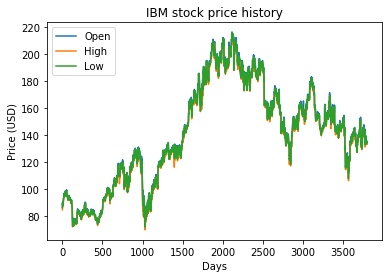

In [4]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_Stock["High"])
plt.plot(df_Stock["Low"])
plt.plot(df_Stock["Close"])
plt.title('IBM stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

### Create Lagged Features for getting Previous day prices for a lookback of 30 days

In [5]:
def prepare_lagged_features(df_Stock, lag_stock, lag_index):

        print('Preparing Lagged Features for Stock, Index Funds.....')
        lags = range(1, lag_stock+1)
        lag_cols= ['Close']
        df_Stock=df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

       
        lags = range(1, lag_index+1)
        lag_cols= ['QQQ_Close','SnP_Close','DJIA_Close']
        df_Stock= df_Stock.assign(**{
            '{}(t-{})'.format(col, l): df_Stock[col].shift(l)
            for l in lags
            for col in lag_cols
        })

        df_Stock = df_Stock.drop(columns=lag_cols)


        remove_lags_na = max(lag_stock, lag_index) + 1
        print('Removing NAN rows - ', str(remove_lags_na))
        df_Stock = df_Stock.iloc[remove_lags_na:,]
        return df_Stock


In [6]:
df_Stock = prepare_lagged_features(df_Stock, lag_stock = 20, lag_index = 5)
df_Stock.head()

Preparing Lagged Features for Stock, Index Funds.....
Removing NAN rows -  21


,Open,High,Low,Close,Diff,High-low,Close(t-1),Close(t-2),Close(t-3),Close(t-4),...,DJIA_Close(t-2),QQQ_Close(t-3),SnP_Close(t-3),DJIA_Close(t-3),QQQ_Close(t-4),SnP_Close(t-4),DJIA_Close(t-4),QQQ_Close(t-5),SnP_Close(t-5),DJIA_Close(t-5)
21,95.25,95.50,94.65,94.89,-0.36,0.85,95.92,95.32,94.79,93.61,...,10539.0098,38.29,1173.4800,10469.8398,37.79,1162.9100,10385.4805,37.92,1164.0800,10386.3701
22,95.30,96.63,95.30,95.46,0.16,1.33,94.89,95.92,95.32,94.79,...,10550.2402,38.66,1184.1700,10539.0098,38.29,1173.4800,10469.8398,37.79,1162.9100,10385.4805
23,95.36,95.70,95.03,95.10,-0.26,0.67,95.46,94.89,95.92,95.32,...,10487.6504,38.83,1183.8101,10550.2402,38.66,1184.1700,10539.0098,38.29,1173.4800,10469.8398
24,94.95,95.16,94.25,94.45,-0.50,0.91,95.10,95.46,94.89,95.92,...,10549.5703,38.59,1175.4301,10487.6504,38.83,1183.8101,10550.2402,38.66,1184.1700,10539.0098
25,94.30,95.40,94.16,95.11,0.81,1.24,94.45,95.10,95.46,94.89,...,10572.5498,39.11,1181.9399,10549.5703,38.59,1175.4301,10487.6504,38.83,1183.8101,10550.2402


In [7]:
df_Stock = df_Stock.drop(columns=['Open', 'High', 'Low'])

In [8]:
df_Stock= df_Stock.iloc[31:452,]
df_Stock.shape

(421, 38)

In [9]:
train=df_Stock.iloc[:340,]
test=df_Stock.iloc[340:,]

In [10]:
train.columns

Index(['Close', 'Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)'],
      dtype='object')

In [11]:
Y_train= train[['Close']]
X_train=train[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]



Y_test= test[['Close']]
X_test= test[['Diff', 'High-low', 'Close(t-1)', 'Close(t-2)', 'Close(t-3)',
       'Close(t-4)', 'Close(t-5)', 'Close(t-6)', 'Close(t-7)', 'Close(t-8)',
       'Close(t-9)', 'Close(t-10)', 'Close(t-11)', 'Close(t-12)',
       'Close(t-13)', 'Close(t-14)', 'Close(t-15)', 'Close(t-16)',
       'Close(t-17)', 'Close(t-18)', 'Close(t-19)', 'Close(t-20)',
       'QQQ_Close(t-1)', 'SnP_Close(t-1)', 'DJIA_Close(t-1)', 'QQQ_Close(t-2)',
       'SnP_Close(t-2)', 'DJIA_Close(t-2)', 'QQQ_Close(t-3)', 'SnP_Close(t-3)',
       'DJIA_Close(t-3)', 'QQQ_Close(t-4)', 'SnP_Close(t-4)',
       'DJIA_Close(t-4)', 'QQQ_Close(t-5)', 'SnP_Close(t-5)',
       'DJIA_Close(t-5)']]

### Scale features for LSTM Training

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(Y_train)

In [13]:
x_train, y_train = [], []
for i in range(60,len(Y_train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

### Create and fit the LSTM network

In [14]:
lstm = Sequential()
lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
lstm.add(LSTM(units=50))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer='adam')
lstm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [15]:
history_lstm = lstm.fit(x_train, y_train, epochs=25, batch_size=5, verbose=2)

Epoch 1/25
 - 4s - loss: 0.0162
Epoch 2/25
 - 3s - loss: 0.0062
Epoch 3/25
 - 3s - loss: 0.0048
Epoch 4/25
 - 3s - loss: 0.0043
Epoch 5/25
 - 3s - loss: 0.0036
Epoch 6/25
 - 4s - loss: 0.0033
Epoch 7/25
 - 4s - loss: 0.0030
Epoch 8/25
 - 4s - loss: 0.0028
Epoch 9/25
 - 4s - loss: 0.0023
Epoch 10/25
 - 4s - loss: 0.0023
Epoch 11/25
 - 5s - loss: 0.0023
Epoch 12/25
 - 4s - loss: 0.0021
Epoch 13/25
 - 4s - loss: 0.0019
Epoch 14/25
 - 4s - loss: 0.0019
Epoch 15/25
 - 4s - loss: 0.0017
Epoch 16/25
 - 4s - loss: 0.0019
Epoch 17/25
 - 4s - loss: 0.0017
Epoch 18/25
 - 4s - loss: 0.0016
Epoch 19/25
 - 4s - loss: 0.0015
Epoch 20/25
 - 4s - loss: 0.0015
Epoch 21/25
 - 4s - loss: 0.0016
Epoch 22/25
 - 4s - loss: 0.0015
Epoch 23/25
 - 4s - loss: 0.0016
Epoch 24/25
 - 4s - loss: 0.0014
Epoch 25/25
 - 4s - loss: 0.0014


In [16]:
history_lstm.history.keys()

dict_keys(['loss'])

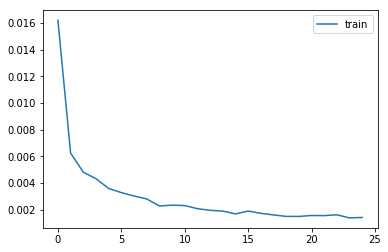

In [17]:
plt.plot(history_lstm.history['loss'], label='train')
#plt.plot(history_lstm.history['val_loss'], label='test')
plt.legend()
plt.show()

In [18]:
new_df_Stock = df_Stock['Close']

In [19]:
#predicting 246 values, using past 60 from the train data
inputs = new_df_Stock[len(new_df_Stock) - len(Y_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [20]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = lstm.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [21]:
rms=np.sqrt(np.mean(np.power((Y_test-closing_price),2)))
rms

Close    0.836111
dtype: float64

In [25]:
closing_price

array([[82.74188 ],
       [83.02702 ],
       [83.02269 ],
       [82.69404 ],
       [82.37769 ],
       [82.470726],
       [82.259544],
       [81.61205 ],
       [80.851715],
       [80.25174 ],
       [79.8861  ],
       [79.70909 ],
       [79.68618 ],
       [79.91817 ],
       [80.423744],
       [80.513824],
       [80.31498 ],
       [80.46827 ],
       [80.085754],
       [79.501495],
       [79.429955],
       [79.26089 ],
       [78.22518 ],
       [77.858864],
       [77.4393  ],
       [77.18827 ],
       [77.43238 ],
       [78.07716 ],
       [78.327614],
       [78.24023 ],
       [78.2041  ],
       [78.30274 ],
       [77.92569 ],
       [77.53226 ],
       [77.31607 ],
       [77.0405  ],
       [76.85173 ],
       [77.18069 ],
       [77.23054 ],
       [77.66385 ],
       [77.9276  ],
       [78.15879 ],
       [77.59927 ],
       [77.14546 ],
       [76.82552 ],
       [76.30773 ],
       [75.51691 ],
       [74.77407 ],
       [74.4209  ],
       [74.52535 ],


In [26]:
closing_price.shape

(81, 1)

In [28]:
Y_test

,Close,predict
392,83.23,82.741882
393,82.90,83.027023
394,82.46,83.022690
395,82.39,82.694038
396,82.89,82.377693
...,...,...
468,79.88,79.000824
469,80.32,79.350121
470,81.40,79.875824
471,81.22,80.744591


In [30]:
def get_mape(y_true, y_pred): 
        """
        Compute mean absolute percentage error (MAPE)
        """
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [31]:
print('R2 - ',round(metrics.r2_score(Y_test.Close,closing_price),2))
print('MAPE - ', round(get_mape(Y_test.Close,closing_price), 2))
print('RMSE -', round(np.sqrt(metrics.mean_squared_error(Y_test.Close,closing_price)),2))
print('MAE - ', round(metrics.mean_absolute_error(Y_test.Close,closing_price),2))


R2 -  0.87
MAPE -  3.24
RMSE - 0.84
MAE -  0.67


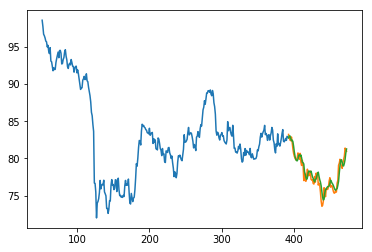

In [22]:
#for plotting
test_result=Y_test
test_result['predict']=closing_price
plt.plot(train['Close'])
plt.plot(test_result[['Close','predict']])

### Conclusion

We got Amazing results by using a 60 day lookup window for Previos Closing Prices, Index funds and by considering the difference between the High low prices.

- R2 -  0.87
- MAPE -  3.24
- RMSE - 0.84
- MAE -  0.67